# About Customize Demo
Module is the core function of the BMF framework, which is the essential instance for executing logic. Users first create a BMG Graph and combine the logic of multiple Modules through serial connection to generate a description graph of the audio and video processing pipeline. When the user executes graph.Run() or graph.start(), the graph description produced by the user will be mapped as a real "executing graph" at the Engine layer. This graph is the real instance for executing the Module processing logic, which is composed of multiple Nodes combined in series, and each Node is bound to a Module instance at the bottom.

The Scheduler in the BMF Engine framework is responsible for scheduling each Node. When constructing a Module instance, the program first reads the metadata of the Module, which defines the type, path, entry, and other information of the Module. After obtaining this information, the program uses a singleton, ModuleManager, to construct the Module instance in reality (by loading it using the corresponding language's loader) and provide it to the Node for use.

For a Module, there are three methods to be implemented mustly: init(), process(), and close(). When the Node is scheduled by the Scheduler, these methods will be executed in turn until the lifecycle ends. The architecture described above can be represented by the following diagram:

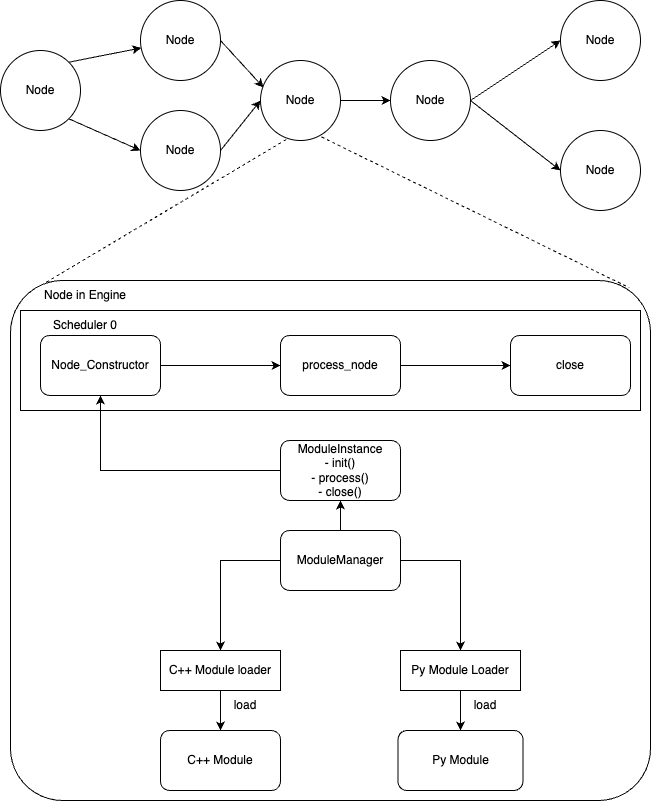

This notebook will show you how to develop Customize Python/C++ Module through the BMF framework as a module developer.Here are the codes with detailed comments:

# 1. Install BMF in Python environment.

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S/view?usp=sharing -O bmf-0.1.0-cp310-none-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=10slUmZnf0x8rOpKUcAnOPFTKYa6tW91S
To: /content/bmf-0.1.0-cp310-none-linux_x86_64.whl
100% 52.6M/52.6M [00:01<00:00, 44.8MB/s]


In [2]:
!pip install bmf-0.1.0-cp310-none-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./bmf-0.1.0-cp310-none-linux_x86_64.whl


## 2.The Engine layer of the BMF framework is uniformly implemented in C++ language. In Colab, when python calls the C++ library, the log of the C++ library layer will be hidden, so it is necessary to install and load the wurlitezer library to enable logs in the C++ layer.

In [3]:
!pip install wurlitzer
%load_ext wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 3. Download a sample transcoded video (using Big Bunny as an example here).

In [4]:
!gdown --fuzzy https://drive.google.com/file/d/1l8bDSrWn6643aDhyaocVStXdoUbVC3o2/view?usp=sharing -O big_bunny_10s_30fps.mp4

Downloading...
From: https://drive.google.com/uc?id=1l8bDSrWn6643aDhyaocVStXdoUbVC3o2
To: /content/big_bunny_10s_30fps.mp4
100% 2.56M/2.56M [00:00<00:00, 191MB/s]


## 4. Write and implement Customize Module Demo
### Overall, Customize Module Demo can be decomposed into three sub-processes:
### 1. Implement the Customize Module used Python.
### 2. Implement the Customize Module used C++.
We will analyze in detail the above two processes one by one.

### Implement the Customize Module used Python
The following code implements a simple Python module, named my_module. In the process method of my_module, it only does one thing: get a packet from the InputQueue, and then push it into the OutputQueue. Essentially, this is a pass-through module.


In [5]:
from bmf import Module, Log, LogLevel, InputType, ProcessResult, Packet, Timestamp, scale_av_pts, av_time_base, \
    BmfCallBackType, VideoFrame, AudioFrame


class my_module(Module):
    def __init__(self, node, option=None):
        self.node_ = node
        self.option_ = option
        pass

    def process(self, task):
        for (input_id, input_packets) in task.get_inputs().items():

            # output queue
            output_packets = task.get_outputs()[input_id]

            while not input_packets.empty():
                pkt = input_packets.get()

                # process EOS
                if pkt.timestamp == Timestamp.EOF:
                    Log.log_node(LogLevel.DEBUG, task.get_node(), "Receive EOF")
                    output_packets.put(Packet.generate_eof_packet())
                    task.timestamp = Timestamp.DONE
                    return ProcessResult.OK

                # copy input packet to output
                if pkt.defined() and pkt.timestamp != Timestamp.UNSET:
                    output_packets.put(pkt)
                    # Log.log_node(LogLevel.DEBUG, self.node_,
                    #              "process input", input_id, 'packet',
                    #              output_packets.queue[0].get_timestamp())

        return ProcessResult.OK


Let's implement a BMF Graph in which we use the module interface to call the my_module we just completed. We set the entry as \_\_main\_\_.my_module because all Python code runs in \_\_main\_\_ in Google Colab.

In [6]:
import bmf
input_video_path = "./big_bunny_10s_30fps.mp4"
output_path = "./custom_module.mp4"

(
    bmf.graph()
        .decode({'input_path': input_video_path})['video']
        .module('my_module',entry='__main__.my_module')
        .encode(None, {"output_path": output_path})
        .run()
)

{
    "input_streams": [],
    "output_streams": [],
    "nodes": [
        {
            "module_info": {
                "name": "c_ffmpeg_decoder",
                "type": "",
                "path": "",
                "entry": ""
            },
            "meta_info": {
                "premodule_id": -1,
                "callback_binding": []
            },
            "option": {
                "input_path": "./big_bunny_10s_30fps.mp4"
            },
            "input_streams": [],
            "output_streams": [
                {
                    "identifier": "video:c_ffmpeg_decoder_0_1",
                    "stream_alias": ""
                }
            ],
            "input_manager": "immediate",
            "scheduler": 0,
            "alias": "",
            "id": 0
        },
        {
            "module_info": {
                "name": "my_module",
                "type": "",
                "path": "",
                "entry": "__main__.my_module"
            }

### Implement the Customize Module used C++
The following code implements a simple C++ module, named copy_module. Unlike the above Python module, copy_module will make a copy of the Input Packet and then push it to the OutputQueue. Compared with my_module, copy_module will do one more copy.

To implement a C++ Module, there are several additional steps that need to be taken. First, download and install the BMF Library. Then, implement the module and CMake File separately to complete the construction of the C++ Module. Finally, a compiled product (.so) will be produced.

In [7]:
!gdown --fuzzy https://drive.google.com/file/d/1XwR5Nx6KvF2ku9CdBVS5i3sA1Whbj1_k/view?usp=sharing -O bmf.zip
!unzip -o bmf.zip

[2023-06-19 12:15:21.152] [info] schedule queue 0 start to join thread
[2023-06-19 12:15:21.152] [info] schedule queue 0 closed
[2023-06-19 12:15:21.152] [info] schedule queue 1 start to join thread
[2023-06-19 12:15:21.152] [info] schedule queue 1 closed
[2023-06-19 12:15:21.152] [info] all scheduling threads were joint
[2023-06-19 12:15:21.152] [info] node id:0 video frame decoded:300
[2023-06-19 12:15:21.152] [info] node id:0 audio frame decoded:0, sample decoded:0
Downloading...
From: https://drive.google.com/uc?id=1XwR5Nx6KvF2ku9CdBVS5i3sA1Whbj1_k
To: /content/bmf.zip
100% 109M/109M [00:05<00:00, 20.0MB/s]
Archive:  bmf.zip
   creating: output/
  inflating: __MACOSX/._output       
   creating: output/3rd_party/
  inflating: output/.DS_Store        
  inflating: __MACOSX/output/._.DS_Store  
   creating: output/example/
   creating: output/bmf/
   creating: output/symbols/
   creating: output/hmp/
  inflating: output/3rd_party/.DS_Store  
  inflating: __MACOSX/output/3rd_party/._.

In [8]:
%%writefile /content/copy_module.h
#ifndef BMF_COPY_MODULE_H
#define BMF_COPY_MODULE_H

#include <bmf/sdk/bmf.h>
#include <bmf/sdk/packet.h>

USE_BMF_SDK_NS

class CopyModule : public Module
{
public:
    CopyModule(int node_id,JsonParam option) : Module(node_id,option) { }

    ~CopyModule() { }

    virtual int process(Task &task);
};

#endif


Writing /content/copy_module.h


In [9]:
%%writefile /content/copy_module.cc
#include "copy_module.h"

int CopyModule::process(Task &task) {
    PacketQueueMap &input_queue_map = task.get_inputs();
    PacketQueueMap::iterator it;

    // process all input queues
    for (it = input_queue_map.begin(); it != input_queue_map.end(); it++) {
        // input stream label
        int label = it->first;

        // input packet queue
        Packet pkt;
        // process all packets in one input queue
        while (task.pop_packet_from_input_queue(label, pkt)) {
            // Get a input packet

            // if packet is eof, set module done
            if (pkt.timestamp() == BMF_EOF) {
                task.set_timestamp(DONE);
                task.fill_output_packet(label, Packet::generate_eof_packet());
                return 0;
            }

            // Get packet data
            // Here we should know the data type in packet
            auto vframe = pkt.get<VideoFrame>();

            // Deep copy
            VideoFrame vframe_out = VideoFrame(vframe.frame().clone());
            vframe_out.copy_props(vframe);

            // Add output frame to output queue
            auto output_pkt = Packet(vframe_out);

            task.fill_output_packet(label, output_pkt);
        }
    }
    return 0;
}
REGISTER_MODULE_CLASS(CopyModule)

Writing /content/copy_module.cc


In [10]:
%%writefile /content/CMakeLists.txt
file(GLOB SRCS *.cc *.h)

add_library(copy_module SHARED ${SRCS})
set_property(TARGET PROPERTY CXX_STANDARD 17)

target_include_directories(
    copy_module
    PRIVATE
    ${CMAKE_CURRENT_SOURCE_DIR}/output/bmf/include
)

target_link_directories(
    copy_module
    PRIVATE
    ${CMAKE_CURRENT_SOURCE_DIR}/output/bmf/lib
)

target_link_libraries(copy_module
    PRIVATE
    bmf_module_sdk
)

Writing /content/CMakeLists.txt


In [11]:
!cmake -DCMAKE_CXX_STANDARD=17 .
!make -j8

CMake Warning (dev) in CMakeLists.txt:
  No project() command is present.  The top-level CMakeLists.txt file must
  contain a literal, direct call to the project() command.  Add a line of
  code such as

    project(ProjectName)

  near the top of the file, but after cmake_minimum_required().

  CMake is pretending there is a "project(Project)" command on the first
  line.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMake Warning (dev) in CMakeLists.txt:
  No cmake_

In [12]:
input_video_path = "./big_bunny_10s_30fps.mp4"
output_path = "./custom_module_c.mp4"

c_module_path = './libcopy_module.so'
c_module_entry = 'copy_module:CopyModule'
# decode
video = bmf.graph().decode({'input_path': input_video_path})
# c module processing
video_2 = (
    video['video'].c_module("copy_module", c_module_path, c_module_entry)
)

# encode
(
    bmf.encode(
        video_2,  # video stream, set to None
        video['audio'],
        {"output_path": output_path,
          "video_params": {
              "vsync": "vfr",
              "max_fr": 60
          },
          "audio_params": {"codec": "aac"}
          }
    ).run()
)

{
    "input_streams": [],
    "output_streams": [],
    "nodes": [
        {
            "module_info": {
                "name": "c_ffmpeg_decoder",
                "type": "",
                "path": "",
                "entry": ""
            },
            "meta_info": {
                "premodule_id": -1,
                "callback_binding": []
            },
            "option": {
                "input_path": "./big_bunny_10s_30fps.mp4"
            },
            "input_streams": [],
            "output_streams": [
                {
                    "identifier": "video:c_ffmpeg_decoder_3_1",
                    "stream_alias": ""
                },
                {
                    "identifier": "audio:c_ffmpeg_decoder_3_2",
                    "stream_alias": ""
                }
            ],
            "input_manager": "immediate",
            "scheduler": 0,
            "alias": "",
            "id": 3
        },
        {
            "module_info": {
            

## 5. Display the video streams before and after processing.

In [13]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return f"""
  <video width={video_width} controls>
    <source src="{video_url}">
  </video>
  """

video_url1 = show_video('big_bunny_10s_30fps.mp4')
video_url2 = show_video('custom_module.mp4')
video_url3 = show_video('custom_module_c.mp4')

html = video_url1 + video_url2 + video_url3
HTML(html)